## Motivation

Benchmark datasets that are challenging for current SOTA models are useful for driving research and progress. New code-specific foundation models released like qwen2.5-coder show that programming is indeed a popular use case for large language models. Structured data like YAML or JSON files are present in many projects, for purposes like storing configuration files or sending data across the network. 

Users may wish to use multiple configuration file formats (e.g. switching cloud providers) ad may choose to use a LLM chatbot to validate their equivalence.

We present, **BenchPRESS**, a benchmark dataset designed to evaluate foundation models on their ability to validate the equivalence of structured data.

## Approach

To create the dataset, we generated 100 exapmles of equivalent files in YAML and JSON format. 

We evaluated the following models:

| Model name         | Creator      | # parameters | License |
|--------------------|-------------|---------------|--------------|
| gpt-4o             | OpenAI      | Unreleased    | Proprietery  |
| gpt-4o-mini        | OpenAI      | Unreleased        | Proprietery  |
| claude-3-5-sonnet  | Anthropic   | Unreleased       | Proprietery  |
| llama-3.1-70b      | Meta        | 70 billion      | Open Source  |
| Mixtral-8x7B-v0.1  | Mistral AI  | 8 billion     | Open Source  |
| llama-3.1-8b       | Meta        | 8 billion     | Open Source  |
| llama-3.2-1b       | Meta        | 1 billion      | Open Source  |
| Qwen/Qwen2.5-0.5B-Instruct       | Alibaba        | 0.5 billion      | Open Source  |
| Qwen2.5-Coder-0.5B-Instruct     | Alibaba        | 0.5 billion      | Open Source  |



In [103]:
!pip install -r requirements.txt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [90]:
LIST_MODELS = {
    'Qwen/Qwen2.5-Coder-0.5B-Instruct': 'local',
    'Qwen/Qwen2.5-0.5B-Instruct': 'local',
    'gpt-4o': 'openai',
    'gpt-4o-mini': 'openai',
    'claude-3-5-sonnet-20241022': 'anthropic',
    'llama3-70b-8192': 'groq',
    'llama-3.1-8b-instant': 'groq',
    'mixtral-8x7b-32768': 'groq',
    'llama-3.2-1b-preview': 'groq',
}

## How to run BenchPRESS
1. Obtain the following API keys:
  - [groq](https://console.groq.com/keys)
  - [OpenAI](https://platform.openai.com/api-keys)
  - [Anthropic](https://www.anthropic.com/api)
2. Create a .env file and insert your api keyas
```bash
cp .example.env .env
```
3. Run scripts below


In [104]:
from openai import OpenAI
import anthropic
from groq import Groq
import os
from dotenv import load_dotenv

load_dotenv()

openai_client = OpenAI(
    api_key=os.getenv('OPENAI_API_KEY')
)

anthropic_client = anthropic.Anthropic(
    api_key=os.getenv('ANTHROPIC_API_KEY')
)

groq_client = Groq(
    api_key=os.getenv('GROQ_API_KEY')
)

In [98]:
from transformers import pipeline
import torch

device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

def load_local_model(model_name):
    return pipeline(
        "text-generation",
        device=device,
        model=model_name,
        model_kwargs={
            "torch_dtype": torch.bfloat16,
        }
    )

model_cache = {model: load_local_model(model) for model in LIST_MODELS if LIST_MODELS[model] == 'local'}

def generate_response(prompt_text, model):
    # print(prompt_text)
    match LIST_MODELS[model]:
        case 'groq':
            output = groq_client.chat.completions.create(
                    messages=[
                        {
                            "role": "user",
                            "content": prompt_text,
                        }
                    ],
                    model=model,
                )
            return output.choices[0].message.content
        case 'openai':
            output = openai_client.chat.completions.create(
                messages=[
                    {
                        "role": "user",
                        "content": prompt_text
                    }
                ],
                model=model
            )
            return output.choices[0].message.content
        case 'anthropic':
            output = anthropic_client.messages.create(
                model=model,
                max_tokens=1024,
                messages=[
                    {"role": "user", "content": prompt_text}
                    ]
                )
            return output.content[0].text
        case 'local':
            pipe = model_cache.get(model)
            if not pipe:
                return "Model not loaded."

            messages = [
                {
                    "role": "system",
                    "content": "You are a helpful assistant that provides useful answers without too much extra output.",
                },
                {
                    "role": "user", 
                    "content": f"{prompt_text}"
                },
            ]

            outputs = pipe(
                messages,
                do_sample=True,
                temperature=0.3,
                max_new_tokens=3,
                pad_token_id=pipe.tokenizer.eos_token_id,
            )

            if outputs:
                return outputs[0]["generated_text"][-1]["content"]
            else:
                return "Sorry!"


In [75]:
# Create BenchPRESS-easy dataset, store in data/easy directory and run evaluation
import os
import random
from datetime import datetime, timedelta
import json
import yaml

os.makedirs("data/easy", exist_ok=True)

num_tests = 50
total_correct = {model: 0 for model in LIST_MODELS}

for i in range(1, num_tests+1):
    folder_name = f"data/easy/pair_{i}"
    os.makedirs(folder_name, exist_ok=True)

    data = {
        "id": i,
        "name": f"Item_{random.choice(['Alpha', 'Beta', 'Gamma', 'Delta', 'Epsilon', 'Zeta', 'Theta'])}_{i}",
        "attributes": {
            "color": random.choice(["blue", "red", "green", "yellow", "purple", "orange", "black", "white"]),
            "size": f"{random.randint(5, 100)}cm",
            "weight": f"{random.uniform(0.5, 20.0):.2f}kg",
            "material": random.choice(["metal", "wood", "plastic", "fabric", "stone", "glass"]),
            "dimensions": {
                "length": f"{random.randint(10, 100)}cm",
                "width": f"{random.randint(10, 100)}cm",
                "height": f"{random.randint(5, 50)}cm"
            }
        },
        "created_at": (datetime.now() - timedelta(days=random.randint(0, 200))).isoformat(),
        "tags": random.sample(["example", "test", "yaml", "json", "data", "unique", "random", "debug", "archive", "vintage"], 4),
        "nested_structure": {
            "sub_id": random.randint(1000, 9999),
            "active": random.choice([True, False]),
            "status": random.choice(["new", "in_progress", "completed", "archived"]),
            "location": {
                "city": random.choice(["Vancouver", "Seattle", "New York", "San Francisco", "Berlin", "Tokyo", "London", "Paris"]),
                "zipcode": random.randint(10000, 99999),
                "coordinates": {
                    "latitude": round(random.uniform(-90.0, 90.0), 6),
                    "longitude": round(random.uniform(-180.0, 180.0), 6)
                }
            },
            "metadata": {
                "creator": {
                    "id": random.randint(1000, 9999),
                    "name": f"User_{random.choice(['Alice', 'Bob', 'Charlie', 'Diana', 'Eve', 'Frank'])}",
                    "roles": random.sample(["admin", "editor", "viewer", "moderator", "contributor"], 2)
                },
                "comments": [
                    {
                        "user": random.choice(["John", "Sarah", "Kate", "Max", "Liam"]),
                        "timestamp": (datetime.now() - timedelta(days=random.randint(0, 50))).isoformat(),
                        "text": f"Comment {random.choice(['Amazing', 'Interesting', 'Needs improvement', 'Completed', 'Pending'])}!"
                    } for _ in range(random.randint(1, 3))
                ]
            },
            "values": [
                {
                    "value_id": random.randint(10000, 99999),
                    "value": random.randint(0, 100),
                    "timestamp": (datetime.now() - timedelta(days=random.randint(0, 200))).isoformat(),
                    "sub_values": [
                        {
                            "sub_value_id": random.randint(1000, 9999),
                            "data": random.uniform(0.1, 10.0),
                            "comment": random.choice(["Good", "Average", "Poor", "Excellent"])
                        } for _ in range(random.randint(1, 3))
                    ]
                }
            ]
        }
    }
    yaml_file_path = os.path.join(folder_name, f"data_{i}.yaml")
    with open(yaml_file_path, "w") as yaml_file:
        yaml.dump(data, yaml_file)

    json_file_path = os.path.join(folder_name, f"data_{i}.json")
    with open(json_file_path, "w") as json_file:
        json.dump(data, json_file, indent=4)

    with open(yaml_file_path) as yf, open(json_file_path) as jf:
        yaml_data = yaml.safe_load(yf)
        json_data = json.load(jf)
        for model in LIST_MODELS:
            print(f"Evaluating: {model}")
            prompt = f"""
            Please determine if the following JSON and YAML representations are pragmatically equivalent. Only respond with "Yes" or "No", if "No", 

            By "pragmatically equivalent," I mean that both representations should express the same data structure and values, ignoring differences in formatting, key order, and type representation. This includes values like timestamps, data types (strings vs numbers), and lists/arrays order.

            JSON:
            {json.dumps(json_data, indent=2)}

            ---

            YAML:
            {yaml.dump(yaml_data, default_flow_style=False, allow_unicode=True)}
            """
            output = generate_response(prompt_text=prompt, model=model)
            print(output)
            if output and "Yes" in output:
                total_correct[model] = total_correct.get(model, 0) + 1

    print(f"{i}/{num_tests} completed")

print(total_correct)

Evaluating: Qwen/Qwen2.5-Coder-0.5B-Instruct
No
Evaluating: Qwen/Qwen2.5-0.5B-Instruct
Yes
Evaluating: gpt-4o
Yes
Evaluating: gpt-4o-mini
No
Evaluating: claude-3-5-sonnet-20241022
Yes
Evaluating: llama3-70b-8192
Yes
Evaluating: llama-3.1-8b-instant
Yes
Evaluating: mixtral-8x7b-32768
Yes
Evaluating: llama-3.2-1b-preview
Yes
1/50 completed
Evaluating: Qwen/Qwen2.5-Coder-0.5B-Instruct
No
Evaluating: Qwen/Qwen2.5-0.5B-Instruct
Yes
Evaluating: gpt-4o
Yes
Evaluating: gpt-4o-mini
No
Evaluating: claude-3-5-sonnet-20241022
Yes
Evaluating: llama3-70b-8192
Yes
Evaluating: llama-3.1-8b-instant
Yes
Evaluating: mixtral-8x7b-32768
Yes, both the JSON and YAML representations are pragmatically equivalent as they express the same data structure and values. The differences in formatting, key order, and type representation (like timestamps, data types, and lists/arrays order) have been appropriately ignored in this comparison.
Evaluating: llama-3.2-1b-preview
JSON:
**
attributes:
  color: string
  size: s

In [100]:
# Create BenchPRESS-hard dataset, store in data/hard directory and run evaluation
def generate_new_json():
    data = {
        "id": i,
        "name": f"Item_{random.choice(['Alpha', 'Beta', 'Gamma', 'Delta', 'Epsilon', 'Zeta', 'Theta'])}_{i}",
        "attributes": {
            "color": random.choice(["blue", "red", "green", "yellow", "purple", "orange", "black", "white"]),
            "size": f"{random.randint(5, 100)}cm",
            "weight": f"{random.uniform(0.5, 20.0):.2f}kg",
            "material": random.choice(["metal", "wood", "plastic", "fabric", "stone", "glass"]),
            "dimensions": {
                "length": f"{random.randint(10, 100)}cm",
                "width": f"{random.randint(10, 100)}cm",
                "height": f"{random.randint(5, 50)}cm"
            }
        },
        "created_at": (datetime.now() - timedelta(days=random.randint(0, 200))).isoformat(),
        "tags": random.sample(["example", "test", "yaml", "json", "data", "unique", "random", "debug", "archive", "vintage"], 4),
        "nested_structure": {
            "sub_id": random.randint(1000, 9999),
            "active": random.choice([True, False]),
            "status": random.choice(["new", "in_progress", "completed", "archived"]),
            "location": {
                "city": random.choice(["New York", "San Francisco", "Berlin", "Tokyo", "London", "Paris"]),
                "zipcode": random.randint(10000, 99999),
                "coordinates": {
                    "latitude": round(random.uniform(-90.0, 90.0), 6),
                    "longitude": round(random.uniform(-180.0, 180.0), 6)
                }
            },
            "metadata": {
                "creator": {
                    "id": random.randint(1000, 9999),
                    "name": f"User_{random.choice(['Alice', 'Bob', 'Charlie', 'Diana', 'Eve', 'Frank'])}",
                    "roles": random.sample(["admin", "editor", "viewer", "moderator", "contributor"], 2)
                },
                "comments": [
                    {
                        "user": random.choice(["John", "Sarah", "Kate", "Max", "Liam"]),
                        "timestamp": (datetime.now() - timedelta(days=random.randint(0, 50))).isoformat(),
                        "text": f"Comment {random.choice(['Amazing', 'Interesting', 'Needs improvement', 'Completed', 'Pending'])}!"
                    }
                ]
            },
            "values": [
                {
                    "value_id": random.randint(10000, 99999),
                    "value": random.randint(0, 100),
                    "timestamp": (datetime.now() - timedelta(days=random.randint(0, 200))).isoformat(),
                    "sub_values": [
                        {
                            "sub_value_id": random.randint(1000, 9999),
                            "data": random.uniform(0.1, 10.0),
                            "comment": random.choice(["Good", "Average", "Poor", "Excellent"])
                        }
                    ]
                }
            ]
        }
    }

    return data

os.makedirs("data/hard", exist_ok=True)

num_tests = 50
total_correct_hard = {model: 0 for model in LIST_MODELS}

for i in range(1, num_tests+1):
    folder_name = f"data/hard/pair_{i}"
    os.makedirs(folder_name, exist_ok=True)

    data_a = generate_new_json()
    data_b = generate_new_json()
    while (data_a == data_b):
        data_a = generate_new_json()

    yaml_file_path = os.path.join(folder_name, f"data_{i}.yaml")
    with open(yaml_file_path, "w") as yaml_file:
        yaml.dump(data_a, yaml_file)

    json_file_path = os.path.join(folder_name, f"data_{i}.json")
    with open(json_file_path, "w") as json_file:
        json.dump(data_b, json_file, indent=4)

    with open(yaml_file_path) as yf, open(json_file_path) as jf:
        yaml_data = yaml.safe_load(yf)
        json_data = json.load(jf)
        for model in LIST_MODELS:
            print(f"Evaluating: {model}")
            prompt = f"""
            Determine if these JSON and YAML representations have identical attribute structures.
            Respond with "Yes" or "No".
            By "identical attribute structures," I mean the same nested keys and hierarchy, regardless of specific values or formatting.

            JSON:
            {json.dumps(json_data, indent=2)}

            ---

            YAML:
            {yaml.dump(yaml_data, default_flow_style=False, allow_unicode=True)}
            """
            output = generate_response(model=model, prompt_text=prompt)
            
            if output and "Yes" in output:
                total_correct_hard[model] = total_correct_hard.get(model, 0) + 1
                print("Correct")
            else:
                print(f"Wrong: {output}")

    print(f"{i}/{num_tests} completed")
    print(total_correct_hard)

print(total_correct_hard)

Evaluating: Qwen/Qwen2.5-Coder-0.5B-Instruct
Wrong: No
Evaluating: Qwen/Qwen2.5-0.5B-Instruct
Wrong: No
Evaluating: gpt-4o
Correct
Evaluating: gpt-4o-mini
Wrong: No
Evaluating: claude-3-5-sonnet-20241022
Correct
Evaluating: llama3-70b-8192
Correct
Evaluating: llama-3.1-8b-instant
Wrong: No
Evaluating: mixtral-8x7b-32768
Wrong: No, these JSON and YAML representations do not have identical attribute structures. Here are some discrepancies:

1. The `color` attribute has the value "blue" in JSON and "yellow" in YAML.
2. The `size` attribute has different values: "34cm" in JSON and "96cm" in YAML.
3. The `weight` attribute has different values: "16.50kg" in JSON and "19.53kg" in YAML.
4. The `material` attribute has different values: "fabric" in JSON and "plastic" in YAML.
5. The `dimensions` have different values for `height`, `length`, and `width`.
6. The `nested_structure.active` attribute has different values: `true` in JSON and `false` in YAML.
7. The `nested_structure.location` has di

## Data

The generated data files are provided in the `data/` folder. `BenchPRESS-easy` can be found in `data/easy` and `BenchPRESS-hard` can be found in `data/hard`. Each folder within `data/easy`/`data/hard` contains an equivalent `.json` and `.yaml` file (e.g. `pair_0` contains `data_0.json` and `data_0.yaml` which are used in the same prompt)

## Code

I used the Anthropic, OpenAI APIs to access their models. I used [groq](http://groq.com) for fast inference on open-source models. For open-source models that aren't available on groq, I used downloaded them from [HuggingFace](https://huggingface.co) and ran them locally on my laptop reusing the inference code from [Homework 4](https://github.com/anoopsarkar/nlp-class-hw/blob/main/prefopt/answer/default.py), except I lowered the `max_new_tokens` to `3` since we're expecting "Yes" or "No" outputs.

I used the `PyYAML` and (json)[https://docs.python.org/3/library/json.html] Python libraries to generate the dataset, and used the Python `random` libary to randomize data values in each `.yaml` and `.json` file.

The prompt used, dataset creation, and evaluation script can be found above in this notebook.

## Experimental Setup

We evaluated the models using a prompt of the following format:

```text
EXAMPLE PROMPT:
"""
Tell me if the YAML is equivalent to the JSON. Only respond "Yes" or 'No", nothing else.
{
  "json": [
    "rigid",
    "better for data interchange"
  ],
  "yaml": [
    "slim and flexible",
    "better for configuration"
  ],
  "object": {
    "key": "value",
    "array": [
      {
        "null_value": null
      },
      {
        "boolean": true
      },
      {
        "integer": 1
      },
      {
        "alias": "aliases are like variables"
      },
      {
        "alias": "aliases are like variables"
      }
    ]
  },
  "paragraph": "Blank lines denote\nparagraph breaks\n",
  "content": "Or we\ncan auto\nconvert line breaks\nto save space",
  "alias": {
    "bar": "baz"
  },
  "alias_reuse": {
    "bar": "baz"
  }
}
---
# <- yaml supports comments, json does not
# did you know you can embed json in yaml?
# try uncommenting the next line
# { foo: 'bar' }
json:
  - rigid
  - better for data interchange
yaml:
  - slim and flexible
  - better for configuration
object:
  key: value
  array:
    - null_value: null
    - boolean: true
    - integer: 1
    - alias: aliases are like variables
    - alias: aliases are like variables
paragraph: |
  Blank lines denote
  paragraph breaks
content: |-
  Or we
  can auto
  convert line breaks
  to save space
alias:
  bar: baz
alias_reuse:
  bar: baz
"""
RESPONSE:
"""
Yes
"""
```

The above is an example of the format we would use as aa prompt in `BenchPRESS-easy`. `BenchPRESS-hard` follows a similar format with equivalent attributes, but we make the values different, evaluating the LLM's ability to analyze and handle disrepancies logically.

We will evaluate each model's performance based on whether they perform this classification task correctly on each example automatically (see above scripts).

## Results

Model: Qwen/Qwen2.5-Coder-0.5B-Instruct | Performance: 0.0
Model: Qwen/Qwen2.5-0.5B-Instruct | Performance: 100.0
Model: gpt-4o | Performance: 100.0
Model: gpt-4o-mini | Performance: 68.0
Model: claude-3-5-sonnet-20241022 | Performance: 100.0
Model: llama3-70b-8192 | Performance: 96.0
Model: llama-3.1-8b-instant | Performance: 100.0
Model: mixtral-8x7b-32768 | Performance: 100.0
Model: llama-3.2-1b-preview | Performance: 34.0


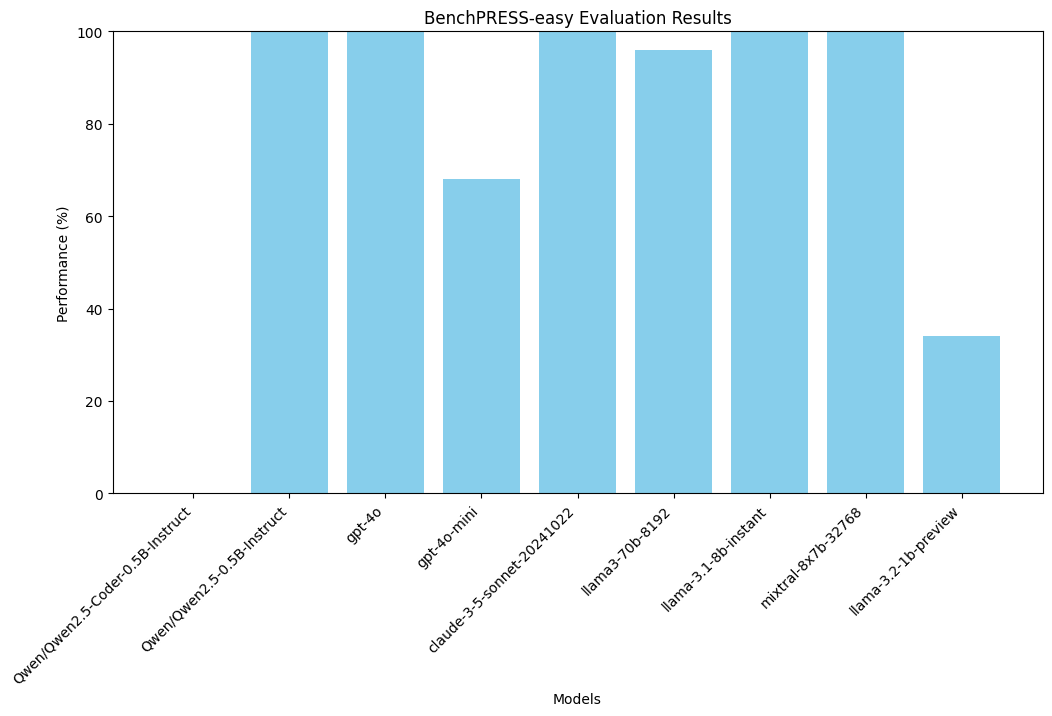

In [86]:
# BenchPRESS-easy Evaluation Results

import matplotlib.pyplot as plt

for model in total_correct:
    print(f"Model: {model} | Performance: {total_correct[model] / num_tests * 100}")
models = list(total_correct.keys())
performance = [total_correct[model] / num_tests * 100 for model in models]

plt.figure(figsize=(12, 6))
plt.bar(models, performance, color='skyblue')
plt.xlabel('Models')
plt.ylabel('Performance (%)')
plt.title('BenchPRESS-easy Evaluation Results')
plt.ylim(0, 100)
plt.xticks(rotation=45, ha='right')
plt.show()

Model: Qwen/Qwen2.5-Coder-0.5B-Instruct | Performance: 0.0
Model: Qwen/Qwen2.5-0.5B-Instruct | Performance: 2.0
Model: gpt-4o | Performance: 96.0
Model: gpt-4o-mini | Performance: 0.0
Model: claude-3-5-sonnet-20241022 | Performance: 100.0
Model: llama3-70b-8192 | Performance: 96.0
Model: llama-3.1-8b-instant | Performance: 40.0
Model: mixtral-8x7b-32768 | Performance: 0.0
Model: llama-3.2-1b-preview | Performance: 24.0


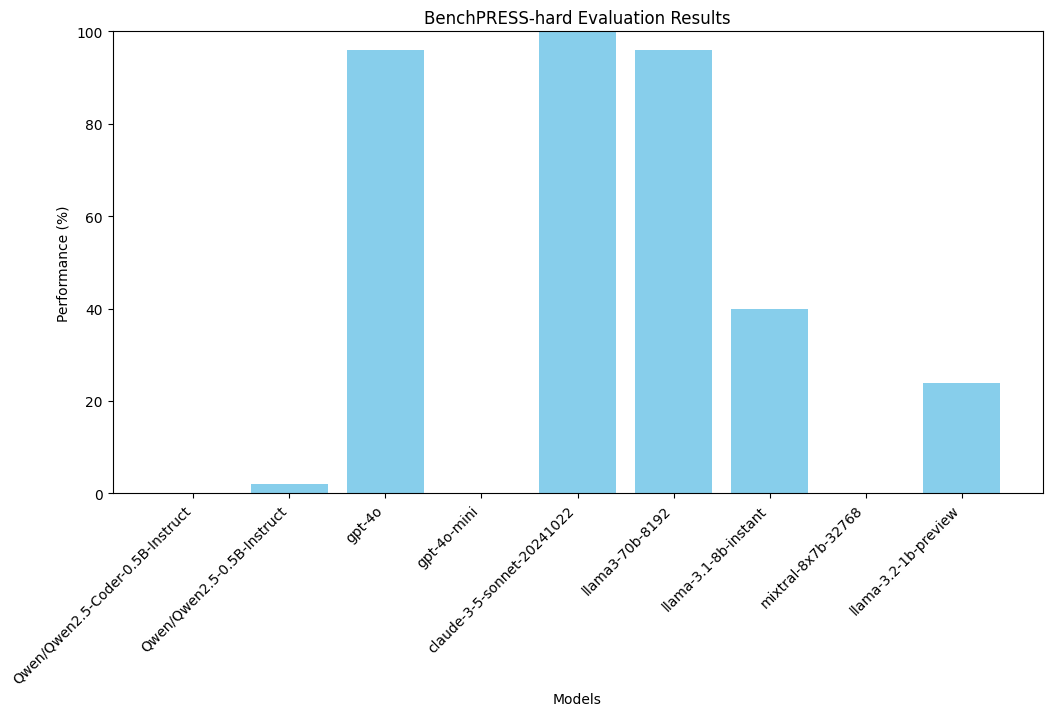

In [101]:
# BenchPRESS-hard Evaluation Results

import matplotlib.pyplot as plt

for model in total_correct_hard:
    print(f"Model: {model} | Performance: {total_correct_hard[model] / num_tests * 100}")
models = list(total_correct_hard.keys())
performance = [total_correct_hard[model] / num_tests * 100 for model in models]

plt.figure(figsize=(12, 6))
plt.bar(models, performance, color='skyblue')
plt.xlabel('Models')
plt.ylabel('Performance (%)')
plt.title('BenchPRESS-hard Evaluation Results')
plt.ylim(0, 100)
plt.xticks(rotation=45, ha='right')
plt.show()

## Analysis of results

The larger size models generally performed better as expected during our evaluation run consisting of 50 examples (i.e. we evaluated each model with 50 prompts each), with some interesting exceptions:

1. The proprietery `gpt4o-mini` performed much worse than many open-source models, including `llama` and `mixtral`
2. The 70 billion parameter `llama` model performed worse than the much smaller 8 billion parameter `llama` model, 8 billion parameter `mixtral` model, and 0.5 billion parameter model `qwen2.5` model

It is also interesting to note that the differences between larger and smaller models in the `BenchPRESS-hard` evaluation are more apparent, with `gpt4o-mini`, `qwen2.5`, and `mixtral-8x-7b` getting a score of 0. `claude-sonnet-3.5` is the top performer in this category at 100% accuracy, followed by `gpt-4o-` and the 70 billion parameter `llama3` model and performing at 96.0%, and the 8 billion parameter `llama3` model at 40%.

The high scores of the smaller open-source models is very interesting, as it shows that these models are competitive with their much larger and more expensive counterparts. The 8 billion and 0.5 billion parameter models are small enough to run on most modern consumer hardware (I ran these experiments on my laptop) which is relevant to this experiement, since in real use cases, YAML and JSON files can contain sensitive data that users may not want to use a cloud-hosted model.

## Future Work

It would be interesting to find out why some models perform better than others, and how the models reason correctly (or incorrectly) about the data's equivalence. Perhaps it would be useful to evaluate and ask the LLM to explain why it chose its answer.

I would also like to benchmark more models on a larger dataset (more examples) if more compute resources are available to get a more reliable result.